# PyTorch Basics - RNN

### By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through basics of RNN on PyTorch.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0)

## Types of RNNs

RNNs are mainly used in case of sequential data such as time series or NLP. There are multiple different types of RNNs which are used for different applications.  

<img src="../../assets/rnn_karpathy.jpeg" />

For Time Series -   
* Forecasting - many-to-many or many-to-one
* Classification - many-to-one 

For NLP - 

* Text Classification: many-to-one
* Text Generation: many-to-many
* Machine Translation: many-to-many
* Named Entity Recognition: many-to-many
* Image Captioning: one-to-many


### Stacked RNNs

We often stack RNNs together for better performance.

<img src="../../assets/stacked_lstm.png" />


### Bidirectional RNN

Bidirectional RNN is essentially using 2 RNNs where the input sequence is fed in the normal order to 1 RNN and in reverse to the other RNN.

<img src="../../assets/birnn.png" />


This notebook explains RNNs in PyTorch by predicting a series of numbers. Let's begin!

## Input Data

Here the data is:   
`[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]`   

We divide it into 4 batches of sequence length = 5.  
`[[1, 2, 3, 4, 5],  
[6, 7, 8, 9, 10],  
[11, 12, 13, 14, 15],  
[16, 17, 18, 19, 20]]`


**Batch Size** = 4  
**Sequence Length** = 5  
**Input Size** = 1 (Since, only one dimension)  


In our case, we're looking at 5 (seq_len) previous value to predict the next 2 values.

In [2]:
data = torch.Tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

print("Data: ", data.shape, "\n\n", data)

Data:  torch.Size([20]) 

 tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20.])


## RNN

### RNN Config

In [3]:
# Number of features used as input. (Number of columns)
INPUT_SIZE = 1

# Number of previous time stamps taken into account.
SEQ_LENGTH = 5

# Number of features in last hidden state ie. number of output time-steps to predict.
# See image below for more clarity.
HIDDEN_SIZE = 2

# Number of stacked rnn layers.
NUM_LAYERS = 1

# We have total of 20 rows in our input. 
# We divide the input into 4 batches where each batch has only 1 row.
# Each row corresponds to a sequence of length 5. 
BATCH_SIZE = 4

### Input

`torch.nn.RNN` has two inputs - `input` and `h_0` ie. the input sequence and the hidden-layer at t=0.
If we don't initialize the hidden layer, it will be auto-initiliased by PyTorch to be all zeros.   

* `input` is the sequence which is fed into the network. 
    * It should be of size `(seq_len, batch, input_size)`. If `batch_first=True`, the input size is `(batch, seq_len, input_size)`.  


* `h_0` is the initial hidden state of the network. 
    * It is of the size `(num_layers * num_directions, batch, input_size)` where `num_layers` is the number of stacked RNNs. `num_directions` = 2 for bidirectional RNNs and 1 otherwise. 




### Output

`torch.nn.RNN` has two outputs - `out` and `hidden`.   

* `out` is the **output of the RNN from all timesteps from the last RNN layer**. 
    * It is of the size `(seq_len, batch, num_directions * hidden_size)`. If `batch_first=True`, the output size is `(batch, seq_len, num_directions * hidden_size)`.


* `h_n` is **the hidden value from the last time-step of all RNN layers**. 
    * It is of the size `(num_layers * num_directions, batch, hidden_size)`. `h_n` is unaffected by `batch_first=True`. 
    * [Github Issue](https://github.com/pytorch/pytorch/issues/4145). 



The following diagram explains it more clearly. Here the `batch=1`. The diagram is for an LSTM which as two hidden parameters `(h, c)`. RNN and GRU both have only `h`.   
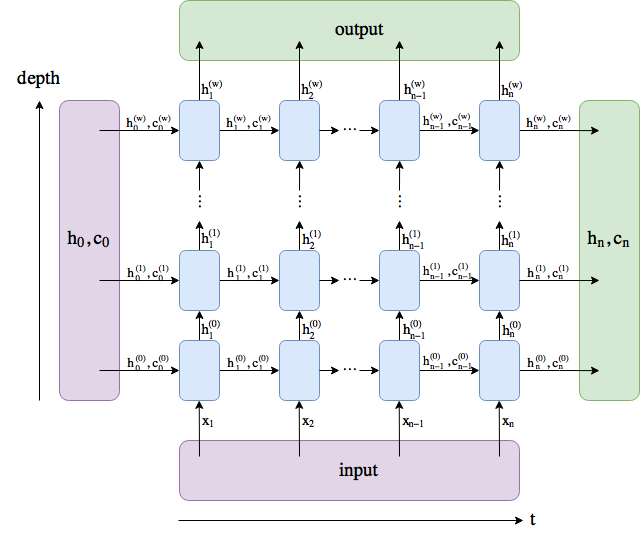  

Credits: https://stackoverflow.com/a/48305882/9193380

To reiterate -
> `out` is the **output of the RNN from all timesteps from the last RNN layer**.   
> `h_n` is **the hidden value from the last time-step of all RNN layers**. 


In [4]:
# Initialize the RNN.
rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers = 1, batch_first=True)

# input size : (batch, seq_len, input_size)
inputs = data.view(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE)

# h_0 size : (num_layers * num_directions, batch, input_size)
# h_0 = torch.randn(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)

# out shape = (batch, seq_len, num_directions * hidden_size)
# h_n shape  = (num_layers * num_directions, batch, hidden_size)
out, h_n = rnn(inputs)

**`input`** shape = `[4, 5, 1]`  
**`out`** shape = `[4, 5, 2]`  
**`h_n`** shape = `[1, 4, 2]`  

In the **`input`** We have 4 batches as our output because we set the `BATCH_SIZE=4`. Each batch contains 5 rows because out `SEQ_LENGTH = 5`. We are using only a single feature as input `INPUT_SIZE = 1`.

In the **`out`**, we get values from all 4 batches where number of time-steps (seq_len) is 5 and the number of predictions are 2. For each batch, we're predicting 2 outputs. 

In the **`h_n`**, we get values from each of the 4 batches of the last time-step of the single RNN layer.

In [5]:
print('Input: ', inputs.shape, '\n', inputs)
print('\nOutput: ', out.shape, '\n', out)
print('\nHidden: ', h_n.shape, '\n', h_n)

Input:  torch.Size([4, 5, 1]) 
 tensor([[[ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.]],

        [[ 6.],
         [ 7.],
         [ 8.],
         [ 9.],
         [10.]],

        [[11.],
         [12.],
         [13.],
         [14.],
         [15.]],

        [[16.],
         [17.],
         [18.],
         [19.],
         [20.]]])

Output:  torch.Size([4, 5, 2]) 
 tensor([[[-0.0819,  0.8100],
         [-0.4311,  0.9332],
         [-0.3162,  0.9748],
         [-0.3979,  0.9875],
         [-0.3675,  0.9944]],

        [[-0.1081,  0.9953],
         [-0.5145,  0.9986],
         [-0.3269,  0.9995],
         [-0.4254,  0.9997],
         [-0.3820,  0.9999]],

        [[-0.1342,  0.9999],
         [-0.5245,  1.0000],
         [-0.3458,  1.0000],
         [-0.4382,  1.0000],
         [-0.3982,  1.0000]],

        [[-0.1601,  1.0000],
         [-0.5328,  1.0000],
         [-0.3648,  1.0000],
         [-0.4506,  1.0000],
         [-0.4143,  1.0000]]], grad_fn=<Transpose

In the output above, notice the last row in each batch of `out` is present in `h_n`. 

* `out` is the output value at all time-steps of the last RNN layer for each batch.  
* `h_n` is the hidden value at the last time-step of all RNN layers for each batch.

## Stacked RNN

If I change the `num_layers = 3`, we will have 3 RNN layers stacked next to each other. See how the `out`, and `h_n` tensors change in the example below.   

We now have 3 batches in the `h_n` tensor. The last batch contains the end-rows of each batch in the `out` tensor.

In [6]:
# Initialize the RNN.
rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers = 3, batch_first=True)

# input size : (batch_size , seq_len, input_size)
inputs = data.view(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE)

# h_0 size : (num_layers * num_directions, batch, input_size)
# h_0 = torch.randn(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)

# out shape = (batch, seq_len, num_directions * hidden_size)
# h_n shape  = (num_layers * num_directions, batch, hidden_size)
out, h_n = rnn(inputs)

**`input`** shape = `[4, 5, 1]`  
**`out`** shape = `[4, 5, 2]`  
**`h_n`** shape = `[3, 4, 2]`  

In the **`input`**, We have 4 batches as our output because we set the `BATCH_SIZE=4`. Each batch contains 5 rows because out `SEQ_LENGTH = 5`. We are using only a single feature as input `INPUT_SIZE = 1`.

In the **`out`**, we get values from all 4 batches where number of time-steps (seq_len) is 5 and the number of predictions are 2. For each batch, we're predicting 2 outputs. 

In the **`h_n`**, we get values from each of the 4 batches of the last time-steps of the 3 stacked RNN layers.

In [7]:
print('Input: ', inputs.shape, '\n', inputs)
print('\nOutput: ', out.shape, '\n', out)
print('\nHidden: ', h_n.shape, '\n', h_n)

Input:  torch.Size([4, 5, 1]) 
 tensor([[[ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.]],

        [[ 6.],
         [ 7.],
         [ 8.],
         [ 9.],
         [10.]],

        [[11.],
         [12.],
         [13.],
         [14.],
         [15.]],

        [[16.],
         [17.],
         [18.],
         [19.],
         [20.]]])

Output:  torch.Size([4, 5, 2]) 
 tensor([[[ 0.3144, -0.7527],
         [-0.0597, -0.6038],
         [ 0.0896, -0.7646],
         [ 0.0608, -0.6358],
         [ 0.1084, -0.6783]],

        [[ 0.4442, -0.6350],
         [ 0.0949, -0.3948],
         [ 0.2715, -0.5962],
         [ 0.1819, -0.4580],
         [ 0.2529, -0.5213]],

        [[ 0.4907, -0.5688],
         [ 0.1671, -0.2976],
         [ 0.3462, -0.4922],
         [ 0.2388, -0.3768],
         [ 0.3078, -0.4418]],

        [[ 0.5041, -0.5466],
         [ 0.1883, -0.2675],
         [ 0.3684, -0.4576],
         [ 0.2572, -0.3502],
         [ 0.3238, -0.4167]]], grad_fn=<Transpose

## Bidirectional RNN

For Bidirectional RNN, we set the `bidirectional=True`.

In [8]:
rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, batch_first=True, num_layers = 1, bidirectional = True)

# input size : (batch_size , seq_len, input_size)
inputs = data.view(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE)

# h_0 size : (num_layers * num_directions, batch, input_size)
# h_0 = torch.randn(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)

# out shape = (batch, seq_len, num_directions * hidden_size)
# h_n shape  = (num_layers * num_directions, batch, hidden_size)
out, h_n = rnn(inputs)

**`input`** shape = `[4, 5, 1]`  
**`out`** shape = `[4, 5, 4]`  
**`h_n`** shape = `[2, 4, 2]`  

In the **`input`** We have 4 batches as our output because we set the `BATCH_SIZE=4`. Each batch contains 5 rows because out `SEQ_LENGTH = 5`. We are using only a single feature as input `INPUT_SIZE = 1`.

In the **`out`**, we get values from all 4 batches where number of time-steps (seq_len) is 5 and the number of predictions are 2. For each batch, we're predicting 2 outputs. Since, it's a bidirectional RNN, we get 2 sets of predictions. Hence, the shape is `[4, 5, 4]` and not `[4, 5, 2]` (*which we observed in the case of a unidirectional RNN above*). 

In the **`h_n`**, we get values from each of the 4 batches of the last time-steps of the single RNN layers. Since, it's a bidirectional RNN, we get 2 sets of predictions. Hence, the shape is `[2, 4, 2]` and not `[1, 4, 2]` (*which we observed in the case of a unidirectional RNN above*). 

In [9]:
print('Input: ', inputs.shape, '\n', inputs)
print('\nOutput: ', out.shape, '\n', out)
print('\nHidden: ', h_n.shape, '\n', h_n)

Input:  torch.Size([4, 5, 1]) 
 tensor([[[ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.]],

        [[ 6.],
         [ 7.],
         [ 8.],
         [ 9.],
         [10.]],

        [[11.],
         [12.],
         [13.],
         [14.],
         [15.]],

        [[16.],
         [17.],
         [18.],
         [19.],
         [20.]]])

Output:  torch.Size([4, 5, 4]) 
 tensor([[[ 0.2184,  0.4086,  0.6418, -0.1677],
         [-0.0222, -0.0095,  0.8794, -0.4927],
         [-0.6716, -0.2802,  0.9585, -0.7248],
         [-0.9387, -0.4152,  0.9846, -0.8646],
         [-0.9841, -0.6164,  0.9789, -0.9192]],

        [[-0.9813, -0.8829,  0.9979, -0.9721],
         [-0.9986, -0.8902,  0.9992, -0.9877],
         [-0.9995, -0.9449,  0.9997, -0.9946],
         [-0.9998, -0.9729,  0.9999, -0.9977],
         [-0.9999, -0.9868,  0.9998, -0.9987]],

        [[-0.9999, -0.9968,  1.0000, -0.9996],
         [-1.0000, -0.9969,  1.0000, -0.9998],
         [-1.0000, -0.9985,  1.0000, -

Let us now try to understand the output in a little more detail. According to the docs, to separate the directions (forward and backward), we can do the following - 

* `out.view(seq_len, batch, num_directions, hidden_size)` with forward and backward being direction 0 and 1 respectively. 

    * Keep in mind that if you used `batch_first=True`, then it would be `out.view(batch, seq_len, num_directions, hidden_size)`.


* `h_n.view(num_layers, num_directions, batch, hidden_size)` with forward and backward being direction 0 and 1 respectively. 

#### BiRNN Separated `out`

Let's reshape the BiRNN output to separate out forward and backward values using `out.view(batch, seq_len, num_directions, hidden_size)`.

In [10]:
out_reshaped = out.view(BATCH_SIZE, SEQ_LENGTH, 2, HIDDEN_SIZE)
print("Shape of the output after directions are separated: ", out_reshaped.shape)

Shape of the output after directions are separated:  torch.Size([4, 5, 2, 2])


The shape is now - `(batch, seq_len, num_directions, hidden_size)`.   

`num_directions` is the 2nd dimension. To obtain forward and backward outputs, we can do the following -

* out_forward = `(batch, seq_len, 0, hidden_size)`  

* out_backward = `(batch, seq_len, 1, hidden_size)`

In [11]:
out_forward = out_reshaped[:, :, 0, :]
out_backward = out_reshaped[:, :, 1, :]

print("Forward output: ", out_forward.shape, "\n", out_forward)
print("\n\nBackward output: ", out_backward.shape, "\n", out_backward)

Forward output:  torch.Size([4, 5, 2]) 
 tensor([[[ 0.2184,  0.4086],
         [-0.0222, -0.0095],
         [-0.6716, -0.2802],
         [-0.9387, -0.4152],
         [-0.9841, -0.6164]],

        [[-0.9813, -0.8829],
         [-0.9986, -0.8902],
         [-0.9995, -0.9449],
         [-0.9998, -0.9729],
         [-0.9999, -0.9868]],

        [[-0.9999, -0.9968],
         [-1.0000, -0.9969],
         [-1.0000, -0.9985],
         [-1.0000, -0.9993],
         [-1.0000, -0.9997]],

        [[-1.0000, -0.9999],
         [-1.0000, -0.9999],
         [-1.0000, -1.0000],
         [-1.0000, -1.0000],
         [-1.0000, -1.0000]]], grad_fn=<SliceBackward>)


Backward output:  torch.Size([4, 5, 2]) 
 tensor([[[ 0.6418, -0.1677],
         [ 0.8794, -0.4927],
         [ 0.9585, -0.7248],
         [ 0.9846, -0.8646],
         [ 0.9789, -0.9192]],

        [[ 0.9979, -0.9721],
         [ 0.9992, -0.9877],
         [ 0.9997, -0.9946],
         [ 0.9999, -0.9977],
         [ 0.9998, -0.9987]],

        

#### BiRNN Separated `h_n`

Let's reshape the BiRNN hidden to separate out forward and backward values using `h_n.view(num_layers, num_directions, batch, hidden_size)`.

In [12]:
h_n_reshaped = h_n.view(1, 2, BATCH_SIZE, HIDDEN_SIZE)
print("Shape of the hidden after directions are separated: ", h_n_reshaped.shape)

Shape of the hidden after directions are separated:  torch.Size([1, 2, 4, 2])


The shape is now - `(num_layers, num_directions, batch, hidden_size)`.   

`num_directions` is the 1st dimension. To obtain forward and backward hidden, we can do the following -

* hidden_forward = `(num_layers, 0, batch, hidden_size)`  

* hidden_backward = `(num_layers, 1, batch, hidden_size)`

In [13]:
h_n_forward = h_n_reshaped[:, 0, :, :]
h_n_backward = h_n_reshaped[:, 1, :, :]

print("Forward h_n: ", h_n_forward.shape, "\n", h_n_forward)
print("\n\nBackward h_n: ", h_n_backward.shape, "\n", h_n_backward)

Forward h_n:  torch.Size([1, 4, 2]) 
 tensor([[[-0.9841, -0.6164],
         [-0.9999, -0.9868],
         [-1.0000, -0.9997],
         [-1.0000, -1.0000]]], grad_fn=<SliceBackward>)


Backward h_n:  torch.Size([1, 4, 2]) 
 tensor([[[ 0.6418, -0.1677],
         [ 0.9979, -0.9721],
         [ 1.0000, -0.9996],
         [ 1.0000, -1.0000]]], grad_fn=<SliceBackward>)


## Stacked Bidirectional RNN

For a Stacked Bidirectional RNN, we set the `bidirectional=True` and `num_layers` = 3.

In [14]:
rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, batch_first=True, num_layers = 3, bidirectional = True)

# input size : (batch_size , seq_len, input_size)
inputs = data.view(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE)

# h_0 size : (num_layers * num_directions, batch, input_size)
# h_0 = torch.randn(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)

# out shape = (batch, seq_len, num_directions * hidden_size)
# h_n shape  = (num_layers * num_directions, batch, hidden_size)
out, h_n = rnn(inputs)

**`input`** shape = `[4, 5, 1]`  
**`out`** shape = `[4, 5, 4]`  
**`h_n`** shape = `[6, 4, 2]`  

In the **`input`** We have 4 batches as our output because we set the `BATCH_SIZE=4`. Each batch contains 5 rows because out `SEQ_LENGTH = 5`. We are using only a single feature as input `INPUT_SIZE = 1`.

In the **`out`**, we get values from all 4 batches where number of time-steps (seq_len) is 5 and the number of predictions are 2. For each batch, we're predicting 2 outputs. Since, it's a bidirectional RNN, we get 2 sets of predictions. Hence, the shape is `[4, 5, 4]` and not `[4, 5, 2]` (*which we observed in the case of a stacked-unidirectional RNN above*). 

In the **`h_n`**, we get values from each of the 4 batches of the last time-steps of the single RNN layers. Since, it's a bidirectional RNN, we get 2 sets of predictions. Hence, the shape is `[6, 4, 2]` and not `[3, 4, 2]` (*which we observed in the case of a stacked-unidirectional RNN above*). 

In [15]:
print('Input: ', inputs.shape, '\n', inputs)
print('\nOutput: ', out.shape, '\n', out)
print('\nHidden: ', h_n.shape, '\n', h_n)

Input:  torch.Size([4, 5, 1]) 
 tensor([[[ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.]],

        [[ 6.],
         [ 7.],
         [ 8.],
         [ 9.],
         [10.]],

        [[11.],
         [12.],
         [13.],
         [14.],
         [15.]],

        [[16.],
         [17.],
         [18.],
         [19.],
         [20.]]])

Output:  torch.Size([4, 5, 4]) 
 tensor([[[-0.4175, -0.6278, -0.0101, -0.4025],
         [ 0.1271, -0.5579,  0.2162, -0.4832],
         [-0.2557, -0.6714,  0.3084, -0.4927],
         [ 0.0556, -0.6295,  0.3194, -0.4467],
         [-0.1510, -0.6863,  0.3917, -0.6299]],

        [[-0.4311, -0.6939, -0.2381, -0.6894],
         [ 0.1423, -0.5335, -0.0872, -0.6471],
         [-0.2943, -0.6468,  0.0076, -0.6274],
         [ 0.0392, -0.5691,  0.0595, -0.5576],
         [-0.2070, -0.6238,  0.2187, -0.6570]],

        [[-0.4458, -0.6581, -0.6259, -0.8299],
         [ 0.0999, -0.4501, -0.5715, -0.8090],
         [-0.3441, -0.5669, -0.4723, -

Let us now try to understand the output in a little more detail. According to the docs, to separate the directions (forward and backward), we can do the following - 

* `out.view(seq_len, batch, num_directions, hidden_size)` with forward and backward being direction 0 and 1 respectively. 

    * Keep in mind that if you used `batch_first=True`, then it would be `out.view(batch, seq_len, num_directions, hidden_size)`.


* `h_n.view(num_layers, num_directions, batch, hidden_size)` with forward and backward being direction 0 and 1 respectively. 

#### Stacked BiRNN Separated `out`

Let's reshape the Stacked BiRNN output to separate out forward and backward values using `out.view(batch, seq_len, num_directions, hidden_size)`.

In [16]:
out_reshaped = out.view(BATCH_SIZE, SEQ_LENGTH, 2, HIDDEN_SIZE)
print("Shape of the output after directions are separated: ", out_reshaped.shape)

Shape of the output after directions are separated:  torch.Size([4, 5, 2, 2])


The shape is now - `(batch, seq_len, num_directions, hidden_size)`.   

`num_directions` is the 2nd dimension. To obtain forward and backward outputs, we can do the following -

* out_forward = `(batch, seq_len, 0, hidden_size)`  

* out_backward = `(batch, seq_len, 1, hidden_size)`

In [17]:
out_forward = out_reshaped[:, :, 0, :]
out_backward = out_reshaped[:, :, 1, :]

print("Forward output: ", out_forward.shape, "\n", out_forward)
print("\n\nBackward output: ", out_backward.shape, "\n", out_backward)

Forward output:  torch.Size([4, 5, 2]) 
 tensor([[[-0.4175, -0.6278],
         [ 0.1271, -0.5579],
         [-0.2557, -0.6714],
         [ 0.0556, -0.6295],
         [-0.1510, -0.6863]],

        [[-0.4311, -0.6939],
         [ 0.1423, -0.5335],
         [-0.2943, -0.6468],
         [ 0.0392, -0.5691],
         [-0.2070, -0.6238]],

        [[-0.4458, -0.6581],
         [ 0.0999, -0.4501],
         [-0.3441, -0.5669],
         [-0.0133, -0.4705],
         [-0.2617, -0.5444]],

        [[-0.4556, -0.6330],
         [ 0.0780, -0.4118],
         [-0.3608, -0.5393],
         [-0.0285, -0.4442],
         [-0.2739, -0.5259]]], grad_fn=<SliceBackward>)


Backward output:  torch.Size([4, 5, 2]) 
 tensor([[[-0.0101, -0.4025],
         [ 0.2162, -0.4832],
         [ 0.3084, -0.4927],
         [ 0.3194, -0.4467],
         [ 0.3917, -0.6299]],

        [[-0.2381, -0.6894],
         [-0.0872, -0.6471],
         [ 0.0076, -0.6274],
         [ 0.0595, -0.5576],
         [ 0.2187, -0.6570]],

        

#### Stacked BiRNN Separated `h_n`

Let's reshape the Stacked BiRNN hidden to separate out forward and backward values using `h_n.view(num_layers, num_directions, batch, hidden_size)`.

In [18]:
h_n_reshaped = h_n.view(3, 2, BATCH_SIZE, HIDDEN_SIZE)
print("Shape of the hidden after directions are separated: ", h_n_reshaped.shape)

Shape of the hidden after directions are separated:  torch.Size([3, 2, 4, 2])


The shape is now - `(num_layers, num_directions, batch, hidden_size)`.   

`num_directions` is the 1st dimension. To obtain forward and backward hidden, we can do the following -

* hidden_forward = `(num_layers, 0, batch, hidden_size)`  

* hidden_backward = `(num_layers, 1, batch, hidden_size)`

In [19]:
h_n_forward = h_n_reshaped[:, 0, :, :]
h_n_backward = h_n_reshaped[:, 1, :, :]

print("Forward h_n: ", h_n_forward.shape, "\n", h_n_forward)
print("\n\nBackward h_n: ", h_n_backward.shape, "\n", h_n_backward)

Forward h_n:  torch.Size([3, 4, 2]) 
 tensor([[[ 0.9455,  0.5653],
         [ 0.9986, -0.1385],
         [ 1.0000, -0.7900],
         [ 1.0000, -0.9272]],

        [[-0.6463,  0.5301],
         [-0.5393,  0.6556],
         [-0.4089,  0.7277],
         [-0.3732,  0.7372]],

        [[-0.1510, -0.6863],
         [-0.2070, -0.6238],
         [-0.2617, -0.5444],
         [-0.2739, -0.5259]]], grad_fn=<SliceBackward>)


Backward h_n:  torch.Size([3, 4, 2]) 
 tensor([[[ 0.1570,  0.2765],
         [ 0.9959,  0.9972],
         [ 1.0000,  1.0000],
         [ 1.0000,  1.0000]],

        [[ 0.0474, -0.5973],
         [ 0.0082, -0.9715],
         [-0.1373, -0.9681],
         [-0.2362, -0.9658]],

        [[-0.0101, -0.4025],
         [-0.2381, -0.6894],
         [-0.6259, -0.8299],
         [-0.7035, -0.8531]]], grad_fn=<SliceBackward>)


You can use the above examples for both LSTM and GRU with minimal code change. 